# import & define

In [1]:
import os
import re
import glob
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim
import torch.nn as nn
#import torchsummary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
#from model import UNet_3Plus, DiceLoss, FocalLoss, IoULoss, Dice_score


import segmentation_models_pytorch as smp

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
#from load_data import *
from run_length_encoding import *
#from load_model import *
from load import *
from loss import *

from collections import OrderedDict

In [2]:
def get_pos_weight(mask):
    pos_weight = torch.zeros(BATCH_SIZE)
    for i in range(len(mask)):
        num_pos = mask[i][mask[i] == 1.].sum()
        num_neg = 224*224
        pos_weight[i] = num_neg/(num_pos + 1e-5)

    return pos_weight

def get_model(model_str: str):
    if model_str == 'Unet':
        return smp.Unet
    elif model_str == 'FPN':
        return smp.FPN
    elif model_str == 'DeepLabV3Plus':
        return smp.DeepLabV3Plus
    elif model_str == 'UnetPlusPlus':
        return smp.UnetPlusPlus
    elif model_str == 'PAN':
        return smp.PAN
    elif model_str == 'MAnet':
        return smp.MAnet
    elif model_str == 'PSPNet':
        return smp.PSPNet
    
    
def get_optimizer(optimizer_str: str):
    if optimizer_str == 'SGD':
        optimizer = torch.optim.SGD
    elif optimizer_str == 'Adam':
        optimizer = torch.optim.Adam
    elif optimizer_str == 'AdamW':
        optimizer = torch.optim.AdamW
    else:
        optimizer = None

    return optimizer

def extract_numbers(string):
    numbers = re.findall(r'\d+', string)
    numbers_list = np.array([int(number) for number in numbers])
    #print(numbers_list)
    return np.max(numbers_list)



# 가장 최근에 저장된 모델의 weight를 가져옵니다.
def get_latest_checkpoint(checkpoint_dir):
    checkpoint_files = glob.glob(os.path.join(checkpoint_dir, '*.pth'))
    if not checkpoint_files:
        #raise FileNotFoundError(f"No checkpoint files found in {checkpoint_dir}")
        return 0, None

    latest_checkpoint = max(checkpoint_files, key=os.path.getctime)
    last_epoch = extract_numbers(latest_checkpoint)
    
    return last_epoch, latest_checkpoint


def get_weight(path): 
    '''
    path : model weight가 저장된 디렉토리
    '''
    last_epoch, last_ckpt_path = get_latest_checkpoint(path)
    if last_epoch == 0:
        return False
    else:
        last_ckpt = torch.load(last_ckpt_path)
        return last_epoch, last_ckpt



def get_multi_gpu_weight(path):
    check_point = torch.load(path)
    new_state_dict = OrderedDict()
    for k, v in check_point.items():
        new_state_dict[k[7:]] = v
    return new_state_dict



def get_transform_for_train(version:int=3):
    
    transform_1 = A.Compose(
        [
            A.Normalize(),
            A.OneOf(
                [
                    A.CoarseDropout(50,50,50,15),
                    A.RandomGridShuffle(grid=(2,2))
                ], p = 0.4),
            A.OneOf(
                [
                    # 블러처리
                    A.ColorJitter(),
                    A.ChannelShuffle()             
                ], p = 0.4),
            A.OneOf(
                [
                    #내가 쓰고자하는 모델에서 input size가 어떤게 적합한가
                    A.Resize (224,224),
                    A.RandomCrop(224,224)
                ],p = 1),
            #A.Resize (224,224),
            ToTensorV2()
        ]
    )
    transform_2 = A.Compose(
        [   
            A.Resize(224, 224),
            A.MinMaxNormalize(),
            A.OneOf([
                A.Flip(p=1),
                A.Rotate(p=1),
            ],p = 1),
            ToTensorV2()
        ]
    )
    # for train_20849_2.csv
    transform_3 = A.Compose(
        [   
            A.Normalize(),
            ToTensorV2()
        ]
    )
    
    if version == 1:
        return transform_1
    elif version == 2:
        return transform_2
    elif version == 3:
        return transform_3


def get_transform_for_test():
    transform = A.Compose(
        [   
            A.MinMaxNormalize(),
            ToTensorV2()
        ]
    )
    return transform


def get_dataset(csv_path, transform, infer = False):
    return SatelliteDataset(csv_file = csv_path, transform = transform, infer = infer)


def random_split_train_valid(dataset):
    data_size = len(dataset)
    train_size = int(data_size*TRAIN_SET_RATIO)
    valid_size = data_size - train_size
    train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])
    return train_dataset, valid_dataset


def get_data_loader(dataset, is_Train = True):
    return DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = is_Train)

# Moel Define & GPU Setting

In [3]:
BATCH_SIZE = 1

In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "1"  # Set the GPUs 0 and 1 to use

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
ARCHITECTURE = 'UnetPlusPlus'
ENCODER = 'timm-efficientnet-b7' #timm-regnety_016
ENCODER_WEIGHT= 'noisy-student' #imagenet
N_CLASSES = 1
ACTIVATION = None
OPTIMIZER = 'AdamW'

In [115]:
ARCHITECTURE = 'Unet'
ENCODER = 'timm-efficientnet-b6' #timm-regnety_016
ENCODER_WEIGHT= 'imagenet' #imagenet
N_CLASSES = 1
ACTIVATION = None

In [7]:
model = get_model(ARCHITECTURE)
model = model(classes=N_CLASSES,
                encoder_name=ENCODER,
                encoder_weights=ENCODER_WEIGHT,
                activation=ACTIVATION)

In [8]:
model

UnetPlusPlus(
  (encoder): EfficientNetEncoder(
    (conv_stem): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): Swish()
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (bn1): BatchNormAct2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): Swish()
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (act1): Swish()
            (conv_expand): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bi

In [9]:
ckpt = torch.load('model_save_unet_3/weight_epoch-0079.pth')

In [8]:
ckpt = torch.load('model_save_UnetPlusPlus_timm-efficientnet-b7_4/UnetPlusPlus_timm-efficientnet-b7-0051.pth')

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [11]:
model = nn.DataParallel(model)

In [12]:
model.load_state_dict(ckpt)

<All keys matched successfully>

In [13]:
model.to(DEVICE)

DataParallel(
  (module): UnetPlusPlus(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (bn1): BatchNormAct2d(
              64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
   

# Pred

In [17]:
BATCH_SIZE = 8

In [18]:
transform_train = get_transform_for_train(version=3)

In [19]:
dataset = get_dataset(csv_path ='/root/jupyter/Dacon/deeplabv3p/test.csv', transform = transform_train, infer = True)
dataloader = get_data_loader(dataset, is_Train=False)

In [20]:
num = 0
test_iter = iter(dataloader)

In [21]:
for i in range(1): # change range
    imgs = next(test_iter)
    num += 1

In [22]:
with torch.no_grad():
    model.eval()
    images = imgs.float().to(DEVICE)
    outputs = model(images)
    outputs = torch.sigmoid(outputs).cpu().numpy()
    outputs = (outputs > .5).astype(np.uint8) # Threshold = 0.35


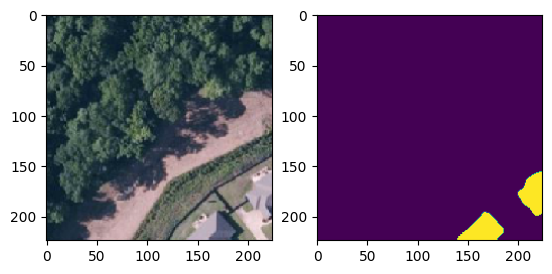

In [30]:
idx = 1
plt.subplot(1,2,1)
plt.imshow(imgs[idx].permute(1,2,0).cpu().numpy())
plt.subplot(1,2,2)
plt.imshow(outputs[idx].squeeze(0)> .5)

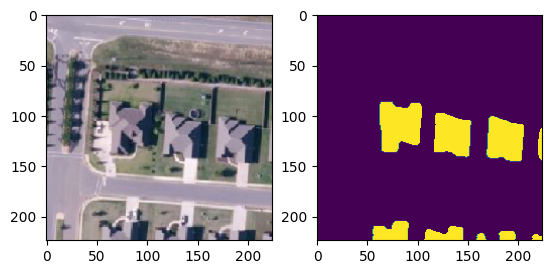

In [31]:
idx = 0
plt.subplot(1,2,1)
plt.imshow(imgs[idx].permute(1,2,0).cpu().numpy())
plt.subplot(1,2,2)
plt.imshow(outputs[idx].squeeze(0)> .5)

In [1]:
def forward(x, y,gamma_neg=4 , gamma_pos=1 , clip = .05, eps = 1e-8):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        # Calculating Probabilities
        x_sigmoid = torch.sigmoid(x)
        xs_pos = x_sigmoid
        xs_neg = 1 - x_sigmoid

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1)

        # Basic CE calculation
        los_pos = y * torch.log(xs_pos.clamp(min=self.eps))
        los_neg = (1 - y) * torch.log(xs_neg.clamp(min=self.eps))
        loss = los_pos + los_neg

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            pt0 = xs_pos * y
            pt1 = xs_neg * (1 - y)  # pt = p if t > 0 else 1-p
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * y + self.gamma_neg * (1 - y)
            one_sided_w = torch.pow(1 - pt, one_sided_gamma)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            loss *= one_sided_w

        return -loss.sum()


## ETC...

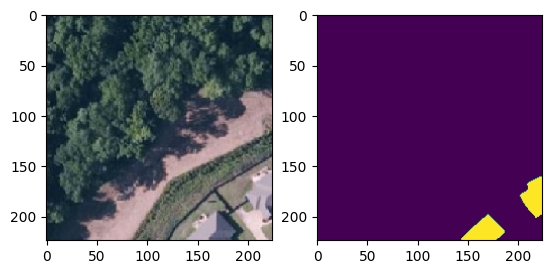

In [24]:
idx = 1
plt.subplot(1,2,1)
plt.imshow(imgs[idx].permute(1,2,0).cpu().numpy())
plt.subplot(1,2,2)
plt.imshow(outputs[idx].squeeze(0)>.5)

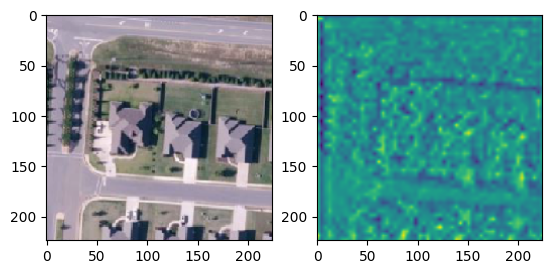

In [20]:
idx = 0
plt.subplot(1,2,1)
plt.imshow(imgs[idx].permute(1,2,0).cpu().numpy())
plt.subplot(1,2,2)
plt.imshow(outputs[idx].squeeze(0))

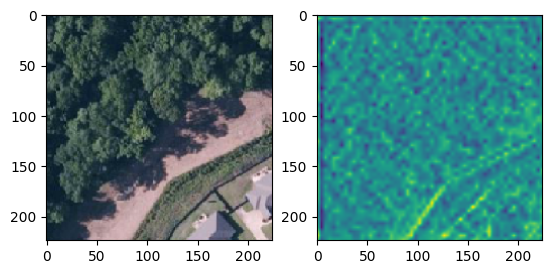

In [21]:
idx = 1
plt.subplot(1,2,1)
plt.imshow(imgs[idx].permute(1,2,0).cpu().numpy())
plt.subplot(1,2,2)
plt.imshow(outputs[idx].squeeze(0))

# Loss Test

In [1]:
import os
import re
import glob
import cv2
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt

import torch
import torch.optim
import torch.nn as nn
#import torchsummary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split


import segmentation_models_pytorch as smp

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
#from load_data import *
from run_length_encoding import *
#from load_model import *
from load import *
from loss import *

from collections import OrderedDict

In [2]:
def get_model(model_str: str):
    if model_str == 'Unet':
        return smp.Unet
    elif model_str == 'FPN':
        return smp.FPN
    elif model_str == 'DeepLabV3Plus':
        return smp.DeepLabV3Plus
    elif model_str == 'UnetPlusPlus':
        return smp.UnetPlusPlus
    elif model_str == 'PAN':
        return smp.PAN
    elif model_str == 'MAnet':
        return smp.MAnet
    elif model_str == 'PSPNet':
        return smp.PSPNet
    
    
def get_optimizer(optimizer_str: str):
    if optimizer_str == 'SGD':
        optimizer = torch.optim.SGD
    elif optimizer_str == 'Adam':
        optimizer = torch.optim.Adam
    elif optimizer_str == 'AdamW':
        optimizer = torch.optim.AdamW
    else:
        optimizer = None

    return optimizer

def extract_numbers(string):
    numbers = re.findall(r'\d+', string)
    numbers_list = np.array([int(number) for number in numbers])
    #print(numbers_list)
    return np.max(numbers_list)



# 가장 최근에 저장된 모델의 weight를 가져옵니다.
def get_latest_checkpoint(checkpoint_dir):
    checkpoint_files = glob.glob(os.path.join(checkpoint_dir, '*.pth'))
    if not checkpoint_files:
        #raise FileNotFoundError(f"No checkpoint files found in {checkpoint_dir}")
        return 0, None

    latest_checkpoint = max(checkpoint_files, key=os.path.getctime)
    last_epoch = extract_numbers(latest_checkpoint)
    
    return last_epoch, latest_checkpoint


def get_weight(path): 
    '''
    path : model weight가 저장된 디렉토리
    '''
    last_epoch, last_ckpt_path = get_latest_checkpoint(path)
    if last_epoch == 0:
        return False
    else:
        last_ckpt = torch.load(last_ckpt_path)
        return last_epoch, last_ckpt



def get_multi_gpu_weight(path):
    check_point = torch.load(path)
    new_state_dict = OrderedDict()
    for k, v in check_point.items():
        new_state_dict[k[7:]] = v
    return new_state_dict



def get_transform_for_train(version:int=3):
    
    transform_1 = A.Compose(
        [
            A.Normalize(),
            A.OneOf(
                [
                    A.CoarseDropout(50,50,50,15),
                    A.RandomGridShuffle(grid=(2,2))
                ], p = 0.4),
            A.OneOf(
                [
                    # 블러처리
                    A.ColorJitter(),
                    A.ChannelShuffle()             
                ], p = 0.4),
            A.OneOf(
                [
                    #내가 쓰고자하는 모델에서 input size가 어떤게 적합한가
                    A.Resize (224,224),
                    A.RandomCrop(224,224)
                ],p = 1),
            #A.Resize (224,224),
            ToTensorV2()
        ]
    )
    transform_2 = A.Compose(
        [   
            A.Resize(224, 224),
            A.MinMaxNormalize(),
            A.OneOf([
                A.Flip(p=1),
                A.Rotate(p=1),
            ],p = 1),
            ToTensorV2()
        ]
    )
    # for train_20849_2.csv
    transform_3 = A.Compose(
        [   
            A.Normalize(),
            ToTensorV2()
        ]
    )
    
    if version == 1:
        return transform_1
    elif version == 2:
        return transform_2
    elif version == 3:
        return transform_3


def get_transform_for_test():
    transform = A.Compose(
        [   
            A.MinMaxNormalize(),
            ToTensorV2()
        ]
    )
    return transform


def get_dataset(csv_path, transform):
    return SatelliteDataset(csv_file = csv_path, transform = transform)


def random_split_train_valid(dataset):
    data_size = len(dataset)
    train_size = int(data_size*TRAIN_SET_RATIO)
    valid_size = data_size - train_size
    train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])
    return train_dataset, valid_dataset


def get_data_loader(dataset, is_Train = True):
    return DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = is_Train)


In [3]:
n_classes = 1
total_pxls = np.zeros((n_classes,1))
BATCH_SIZE = 64
total_pxls

array([[0.]])

In [25]:
dataset = get_dataset(csv_path ='/root/jupyter/Dacon/deeplabv3p/Archive/train_28049_2.csv', transform = get_transform_for_test())
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)

In [ ]:
n_classes = 1
total_pxls = np.zeros((n_classes,BATCH_SIZE))

In [ ]:
total_pxls.shape

In [27]:
train_iter = iter(dataloader)

In [28]:
imgs,msks = next(train_iter)

In [ ]:
new_lbl = np.array(imgs, dtype=np.uint8)
for k in range(0,n_classes):
    total_pxls[k] = np.sum(new_lbl==k)+total_pxls[k]

In [ ]:
total_pxls

In [ ]:
num_pos = msks[0][msks[0] == 1.].sum()
num_pos

In [21]:
num_neg= 224*224
num_neg/num_pos

NameError: name 'num_pos' is not defined

In [23]:
def get_pos_weight(mask):
    pos_weight = torch.zeros(BATCH_SIZE)
    for i in range(len(mask)):
        num_pos = mask[i][mask[i] == 1.].sum()
        num_neg = 224*224
        pos_weight[i] = num_neg/num_pos

    return pos_weight

In [24]:
pos_weights = get_pos_weight(msks)
pos_weights

NameError: name 'msks' is not defined

In [34]:
torch.nn.BCEWithLogitsLoss(pos_weight=pos_weights)

BCEWithLogitsLoss()

In [35]:
x = torch.randn(2, 1, 24, 24, requires_grad=True)
y = torch.zeros(2 * 1 * 24 * 24)
y[torch.randint(0, y.nelement(), (100,))] = 1.
y = y.view_as(x)
print('y: 0s: {}, 1s: {}, nelement: {}'.format(
    (y==0.).sum(), y.sum(), y.nelement()))


criterion = nn.BCEWithLogitsLoss()
loss = criterion(x, y)
print(loss)

criterion_weighted = nn.BCEWithLogitsLoss(pos_weight=(y==0.).sum()/y.sum())
loss_weighted = criterion_weighted(x, y)
print(loss_weighted)

y: 0s: 1055, 1s: 97.0, nelement: 1152
tensor(0.8177, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.4771, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [19]:
y.shape

torch.Size([2, 1, 24, 24])

In [20]:
y = torch.zeros(2 * 1 * 24 * 24)
y[torch.randint(0, y.nelement(), (100,))] = 1.

In [21]:
(y== 0).sum()/y.sum()

tensor(11.1263)

In [36]:
for i in range(len(msks)):
    

0
1
2
3


In [38]:
bceLoss = torch.nn.BCEWithLogitsLoss()
dice_score = DiceScore()

In [40]:
outputs = model(imgs)

In [44]:
bceLoss(outputs,msks.to(device = DEVICE, dtype = torch.float).unsqueeze(1))

tensor(0.1709, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [44]:
pos_weights = get_pos_weight(msks)

In [33]:
losses = []

In [43]:

for i in range(len(msks)):
    losses.append(torch.nn.BCEWithLogitsLoss(pos_weight = pos_weights[i])(outputs[i], msks.to(device = DEVICE, dtype = torch.float).unsqueeze(1)[i]))
    

In [ ]:
losses

In [20]:
for imgs, msks in tqdm(dataloader):
    outputs = model(imgs)
    pos_weights = get_pos_weight(msks)
    for i in range(len(msks)):
        loss_value = torch.nn.BCEWithLogitsLoss(pos_weight = pos_weights[i])(outputs[i], msks.to(device = DEVICE, dtype = torch.float).unsqueeze(1)[i])
        losses.append(torch.nn.BCEWithLogitsLoss(pos_weight = pos_weights[i])(outputs[i], msks.to(device = DEVICE, dtype = torch.float).unsqueeze(1)[i]))


NameError: name 'dataloader' is not defined

In [7]:
float("inf")

inf

In [10]:
print(float("inf"))

inf


In [12]:
import os
import re
import glob
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import torch
import torch.optim
import torch.nn as nn
#import torchsummary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split


import segmentation_models_pytorch as smp

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
#from load_data import *
from IPython.display import display, HTML
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [31]:
contours, hierarchy = cv2.findContours(zero_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/contours.cpp:195: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


In [30]:
zero_img = np.zeros((224,224))
zero_img[:,100:105].fill(1)
zero_img[:,100:105]

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       ...,
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [186]:
imgs = cv2.imread('/root/jupyter/Dacon/deeplabv3p/train_img/TRAIN_0000.png')

In [185]:
torch.ones(1)

tensor([1.])

# FocalLoss

In [195]:
import torch.nn.functional as F

In [188]:
dataset = get_dataset(csv_path ='/root/jupyter/Dacon/deeplabv3p/train.csv', transform = transform_train)
dataloader = get_data_loader(dataset, is_Train=False)

In [189]:
train_iter = iter(dataloader)

In [190]:
imgs,msks = next(train_iter)

In [197]:
imgs.dim()

4

In [198]:
imgs_ = imgs.view(imgs.size(0), imgs.size(1), -1)
imgs_.shape

torch.Size([2, 3, 1048576])

In [199]:
imgs_ = imgs_.transpose(1,2)
imgs_.shape

torch.Size([2, 1048576, 3])

In [203]:
imgs_f = imgs_.contiguous().view(-1,imgs_.size(2))
imgs_f.shape

torch.Size([2097152, 3])

In [210]:
msks_ = msks.view(-1,1)

In [206]:
logpt = F.log_softmax(imgs_f)

/tmp/ipykernel_812080/1633877561.py:1: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(imgs_f)


In [216]:
logpt.shape

torch.Size([2097152, 3])

In [217]:
logpt

tensor([[-1.0807, -1.0563, -1.1620],
        [-1.0831, -1.0628, -1.1522],
        [-1.0844, -1.0640, -1.1494],
        ...,
        [-1.1107, -1.1027, -1.0826],
        [-1.0973, -1.1134, -1.0853],
        [-1.0920, -1.1161, -1.0880]])

In [211]:
logpt_ = logpt.gather(1, msks_.type(torch.int64))

In [218]:
logpt_.shape

torch.Size([2097152, 1])

In [223]:
logpt_.shape

torch.Size([2097152, 1])

In [220]:
logpt_1 = logpt_.view(-1)

In [222]:
logpt_1

torch.Size([2097152])

In [59]:
from losses import AsymmetricLoss
criterion = AsymmetricLoss(gamma_neg=1, gamma_pos=4, clip=0.05, disable_torch_grad_focal_loss=True)